In [73]:
# read data from data set
from utils.data_utils import jigsaw_toxix_ds_get_df
import numpy as np
from config import *
import seaborn as sns
import matplotlib.pyplot as plt
df = jigsaw_toxix_ds_get_df()
comments = df["comment_text"].tolist()
comments = [x.replace('\n', ' ') for x in comments]

classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
dump_text = '\n'.join(comments)
total_classes = 6
class_matrix = df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].astype('int')
label_matrix = class_matrix.values
h_dim = 300


In [2]:
# load word2vec model
import os 
from config import model_folder
from model_factory.embeddings.w2v import w2v_load_from_keyedvectors, build_embedding_layer
w2v_name = 'google_keyed_vector_format.bin'
model_path = os.path.join(model_folder, w2v_name)
print('loading pretrained w2v', end='...')    
w2v_model = w2v_load_from_keyedvectors(model_path)
vocab = w2v_model.vocab
print('done.')
word_2_idx = dict(zip(vocab.keys(), range(len(vocab))))
max_sent_length = 80
trainable = False
print('initialize embedding layer', end='...')
embedding_layer = build_embedding_layer(w2v_model, word_2_idx, 
                                        len(vocab), max_sent_length, trainable)
print('done.')


Using TensorFlow backend.


loading pretrained w2v...done.
initialize embedding layer...done.


In [3]:
# tokenization
import nltk
from keras.preprocessing.sequence import pad_sequences
def tokenizer(text, word2idx, max_len=80, total=None):
    if total is not None:
        text = text[:total]
    for sentence_idx in range(len(text)):
        sentence = text[sentence_idx]
        text[sentence_idx] = nltk.word_tokenize(sentence)
 
    def _sent_to_idx(s, w2i):
        for word_idx in range(len(s)):
            word = s[word_idx]
            idx = w2i.get(word, w2i['null'])
            s[word_idx] = idx
        return s
        
    for sentence_idx in range(len(text)):
        sentence = text[sentence_idx]
        sequence = _sent_to_idx(sentence, word2idx)
        text[sentence_idx] = sequence
    
    text = pad_sequences(text, maxlen=max_len, value=word2idx['null'])   
    return text

num_samples = 50000
print('tokenizing data', end='...')
tokenized_sequence = tokenizer(comments, word_2_idx, max_sent_length, total=num_samples)
if num_samples is not None:
    label_matrix = class_matrix.values[:num_samples]
print('done.')

tokenizing data...done.


In [4]:
# bayes network

from model_factory.lstm_mc_dropout import SeqCLS

m = SeqCLS()
m.configure(None, 
            max_sent_length, 
            total_classes, 300, 
            pretrained_embedding=embedding_layer,
            verbose=1,
            )




In [32]:
# run this block multiple times retrain the same model `m` if `m` if not initialized in this block
epochs=10
print(label_matrix.shape)
# join embeddings with data set dataframe
train_test_split = 0.2
m.fit(tokenized_sequence, label_matrix, epochs=epochs, batch_size=1024, 
      validation_split=train_test_split, shuffle=False)

(50000, 6)
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 159us/step - loss: 0.0988 - val_loss: 0.1312
Epoch 2/10
40000/40000 [==============================] - 6s 158us/step - loss: 0.0976 - val_loss: 0.1312
Epoch 3/10
40000/40000 [==============================] - 6s 157us/step - loss: 0.0977 - val_loss: 0.1300
Epoch 4/10
40000/40000 [==============================] - 6s 157us/step - loss: 0.0978 - val_loss: 0.1307
Epoch 5/10
40000/40000 [==============================] - 6s 158us/step - loss: 0.0955 - val_loss: 0.1315
Epoch 6/10
40000/40000 [==============================] - 6s 158us/step - loss: 0.0959 - val_loss: 0.1337
Epoch 7/10
40000/40000 [==============================] - 6s 158us/step - loss: 0.0950 - val_loss: 0.1340
Epoch 8/10
40000/40000 [==============================] - 6s 157us/step - loss: 0.0951 - val_loss: 0.1324
Epoch 9/10
40000/40000 [==============================] - 6s 158us/step - loss: 0.0935 - va

In [64]:

train_test_split=0.1
divider = int(len(tokenized_sequence)*train_test_split)

test_X = tokenized_sequence[-divider:]
test_Y = label_matrix[-divider:]
test_comments = comments[-divider:]
print(len(test_X), len(test_Y), len(test_comments))
pred_Y, uncertainty_Y = m.predict_with_uncertainty(test_X, sim=10)
topic_Y = test_Y.T
pred_topic_Y = pred_Y.T


5000 5000 5000


(5000, 6)
[ 0.06714571  0.00213848  0.02332289  0.00197746  0.02808471  0.00476734]
topic index toxic
uncertainty percentile 0.128686715163


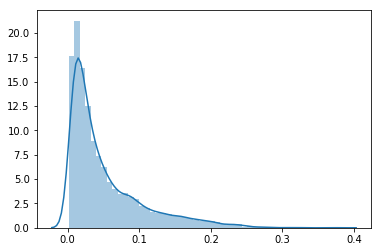

topic index severe_toxic
uncertainty percentile 0.0130376191288


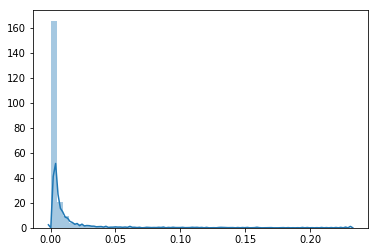

topic index obscene
uncertainty percentile 0.0947761765541


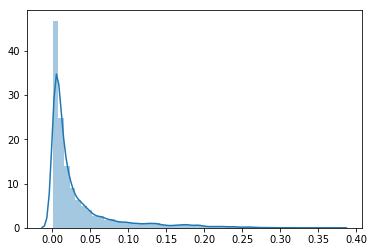

topic index threat
uncertainty percentile 0.0050441217044


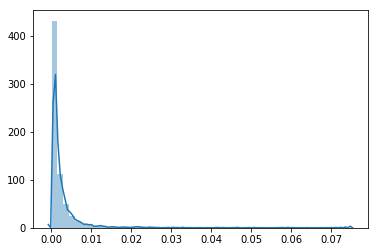

topic index insult
uncertainty percentile 0.0815472304507


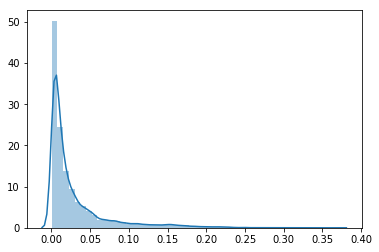

topic index identity_hate
uncertainty percentile 0.0127430327324


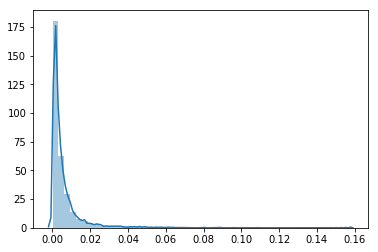

<Figure size 432x288 with 0 Axes>

In [77]:
print(uncertainty_Y.shape)
print(uncertainty_Y[0])

topic_uncertainty = np.swapaxes(uncertainty_Y, 0, -1)
topic_uncertainty_percentils = [0 for _ in range(len(classes))]
for topic_index in range(topic_uncertainty.shape[0]):
    topic_uncertainty_scores = topic_uncertainty[topic_index]
    topic_uncertainty_percentils[topic_index] = np.percentile(topic_uncertainty_scores, 90)
    print('topic index', classes[topic_index])
    print('uncertainty percentile', topic_uncertainty_percentils[topic_index])
    sns.distplot(topic_uncertainty_scores)
    plt.show();plt.cla();plt.clf()

In [66]:
# evaluate performance
threshold = 0.5
print(threshold)
from sklearn.metrics.classification import precision_score, recall_score
print(','.join(['sample size','precision','recall', 'prior']))
# print(pred_topic_Y[0].tolist())
for topic_idx in range(len(pred_topic_Y)):
    true_topic = topic_Y[topic_idx]
    pred_topic = pred_topic_Y[topic_idx]
    pred_topic[np.where(pred_topic >= threshold)] = 1
    pred_topic[np.where(pred_topic < threshold)] = 0
    print('%d, %.2f, %.2f, %.2f' 
          % (sum(true_topic), 
             precision_score(true_topic, pred_topic, average='binary'), 
             recall_score(true_topic, pred_topic), 
             sum(true_topic)/len(true_topic)))


0.5
sample size,precision,recall,prior
455, 0.79, 0.34, 0.09
41, 0.89, 0.20, 0.01
243, 0.79, 0.38, 0.05
13, 0.00, 0.00, 0.00
209, 0.69, 0.33, 0.04
40, 0.00, 0.00, 0.01


/home/pintellect/anaconda3/envs/ml-dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pintellect/anaconda3/envs/ml-dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
# sampling from model

# train_test_split=0.1
# divider = int(len(tokenized_sequence)*train_test_split)
divider = 10
interval = 100
l = 0
sample_X = test_X[l:l+interval]
sample_Y = test_Y[l:l+interval]
sample_comments = test_comments[l:l+interval]

print(comments[0])
samples = m.sample_output(t_X_input, n_iter=100)
sample_pred_y, sample_uncertainties = m.predict_with_uncertainty(t_X_input, sim=100)
print(samples.shape)


Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
(100, 100, 6)


" He has lived in Ruse and his name is Angel Topalov, now he lives in London and I suppose someone is paying him to administrate this anti-bulgarian propaganda on wikipedia, he is spamming other bulgarian-related articles with his turkic crap too. That's his profile http://www.sladur.com/profile.php?id=36630 It is clear that his IQ doesn't fly pretty high as you can conclude by his elementary one-sentence answers such as ""this is not a fantasy forum"", or ""Such fringe views are not welcomed"", he can't even construct one proper sentence with arguements to support his fake turkic propaganda."
topic likelihood toxic
uncertainty 0.142506518368
[0 0 0 0 0 0]


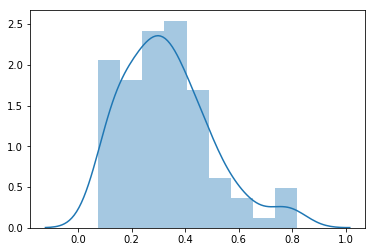

"  Well, I have more creation info to add in.  Do you think the article is saveable?  The description section is just to provide context for the rest of the article, the second section isn't really in-universe since it's about how the vampires were concieved by the writers (and, when I include more info, the make-up guys).  I agree that the article needs to establish more notability, that's the next issue I hope to address.   730 "
topic likelihood toxic
uncertainty 0.213143595849
[0 0 0 0 0 0]


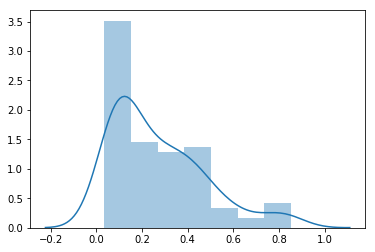

"   LOL   Hello there buddy, remember me? ) Revenge is sweet and is a dish served cold. You eventually exposed to everyone that you are just a hysterical, narcissistic, try-to-be ""intellectual"" who is just simply batshit insane and suffers from an inferior complex, or maybe you just have OCD, ADHD and Aspergers. I am loving my time here, have a nice day now Marcus you poor, sad & pathetic little man.   (LOL again at your block)"
topic likelihood toxic
uncertainty 0.15557431213
[1 0 1 0 1 0]


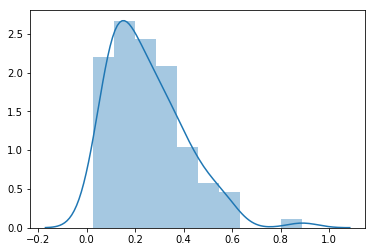

ethnic affiliation is directly relevant for his notability as a writer because his works deal with ethnic questions in the Balkans'''
topic likelihood toxic
uncertainty 0.180111493757
[1 0 1 0 1 1]


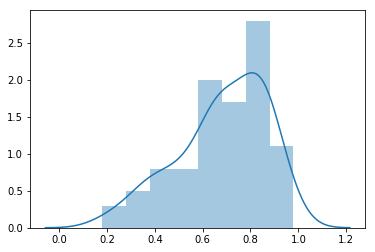

"  Clarification of the ""question mark"" paragraph   I know that the question mark balls are used as wild cards, but I don't understand the following. ""A variety of unusual situations can arise during a game. According to an unauthenticated first-person account by a contestant (A Brush with The Chuck), a wild-card-substituted number drawn in a subsequent round is ignored; the segment is edited out of the aired version of the show"". What do you mean it's ignored, I doubt anybody understand what you meant. Thanks  "
topic likelihood toxic
uncertainty 0.161986754262
[0 0 0 0 0 0]


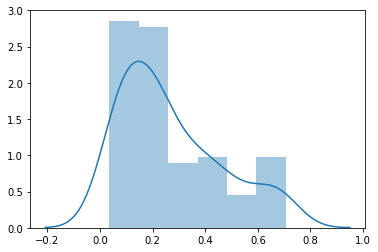

I never touched the template - all I did was edit the list of broadcasters article to reflect updated information, which was WEWS over WKYC, and I removed the STO stuff because (judging by the reference I included straight from the Browns) STO is a non-factor.  And you can easily edit the article in a way that had WEWS in it...you were just looking to pick a fight.  I notice a pattern - you lay low for awhile, then you come out of the clear blue and come up swinging...it's like you have withdrawals need a fix or something.  Go find another dealer.  (talk)
topic likelihood toxic
uncertainty 0.177263335532
[0 0 0 0 0 0]


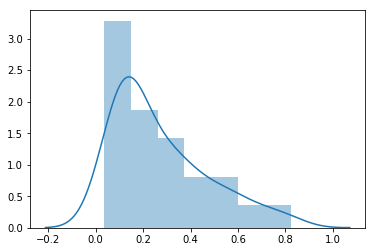

To do #2   What now can I add to this article??? I like a challenge.
topic likelihood toxic
uncertainty 0.130829262953
[1 0 0 0 0 0]


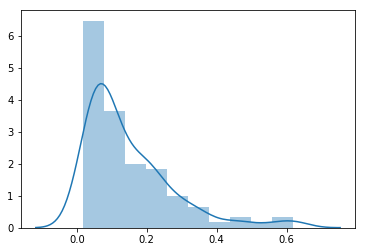

" members would be fine in that context. Volunteer or Volunteers would be used when specifically referring to individuals but it is of to the ""the three were members of the PIRA"" if you are describing them in general terms. "
topic likelihood toxic
uncertainty 0.153705858901
[0 0 0 0 0 0]


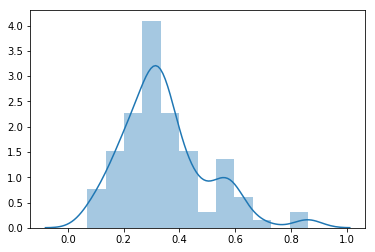

Read the facts, and check the racist User:Jpgordon's behaviour, do not just agree with somenone who is/claims to be an administrator because you are one. Very simple indeed, but does require maturity, not shown here by either User:Kuru or User:Acroterion, who chose to condone and collude with racism of User:Jpgordon.  Ah well.... getting tiresome and disgusting, all this business. Will have to change IP. 59.41.252.228  }}
topic likelihood toxic
uncertainty 0.174934479684
[0 0 0 0 0 0]


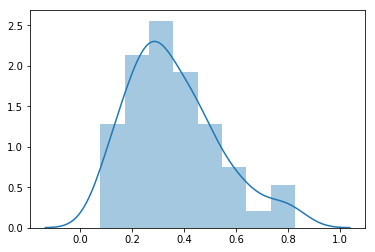

Take everything you have written here and shove it, onto the Historicity of Jesus talk page, where
topic likelihood toxic
uncertainty 0.183368534369
[1 0 0 0 0 0]


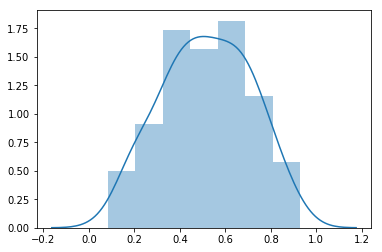

but other call him: partyjniak  22:41, 9 Feb 2004 (UTC)  Moved to talk: The numbers quoted in document are now usually lowered to 20 to 40 Polish soldiers killed in Bydgoszcz at September the first, and in whole about 13.000 inhabitants of Bydgoszcz murdered during the war.  Maybe somebody can updare recent documents of IPN?  22:41, 9 Feb 2004 (UTC)
topic likelihood toxic
uncertainty 0.201180886153
[0 0 0 0 0 0]


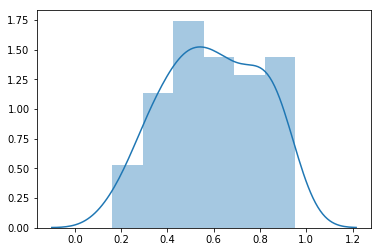

"  Fair use rationale for Image:Las Vegas seal.jpg Thanks for uploading or contributing to Image:Las Vegas seal.jpg. I notice the image page specifies that the image is being used under fair use but there is not a suitable explanation or rationale as to why each specific use in Wikipedia constitutes fair use. Please go to the image description page and edit it to include a fair use rationale.  If you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of 'image' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any non-free media lacking such an explanation will be deleted one week after they have been uploaded, as described on criteria for speedy deletion. If you have any questions please ask them at the Media copyright questions page. Thank y

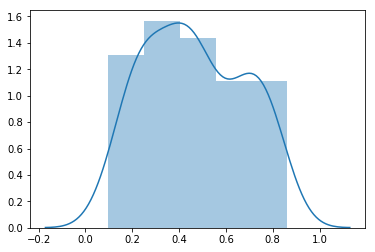

I know for a fact that it consists of 60-70% percent voters who supported Hussein Obama, but I did that before and a Wikipedian argued that has nothing to do with being liberal. 76.102.193.102
topic likelihood toxic
uncertainty 0.16017372197
[1 0 0 0 1 1]


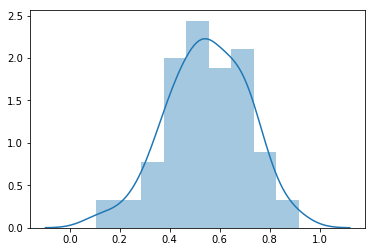

I didn't mean wt u think.   Dear.. I seriously didn't mean any kind of war... I dnt even knw wt u mean by edit dispute war & All that... I did undo ur edit but not as a war.. I just wanted the page to b there.. N instead of writing the whole article again i thought just undoing ur edit will b easy. I didn't mean war...  I dnt knw y u want the page to b redirected... U wont lose anything by keeing that page.. N u wont gain anything by redirecting that page... Please... Dnt do it.. I request u... This is very important for me & many fans of Show... I please request you not to redirect the page.. I hope u keep some value of my request...
topic likelihood toxic
uncertainty 0.161671360222
[0 0 0 0 0 0]


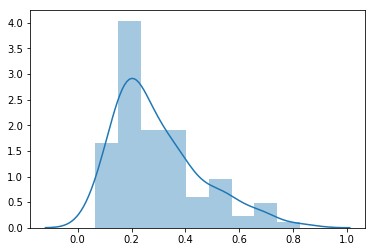

<Figure size 432x288 with 0 Axes>

In [89]:

sample_cpy = np.array(samples)
sample_cpy = np.swapaxes(sample_cpy, 0, -1)
sample_uncertainties_cpy = np.swapaxes(sample_uncertainties, 0, -1)

for topic_idx in range(sample_cpy.shape[0]):
    for data_idx in range(sample_cpy.shape[1]):
        sim_samples = sample_cpy[topic_idx][data_idx]
        if topic_idx == 0:
            sampe_uncertainty = sample_uncertainties_cpy[topic_idx][data_idx]
            if sampe_uncertainty < topic_uncertainty_percentils[topic_idx]:
                continue
            sns.distplot(sim_samples)
            print(sample_comments[data_idx])
            print('topic likelihood', classes[topic_idx])
            print('uncertainty',  sampe_uncertainty)
            print(sample_Y[data_idx])
            plt.show();plt.cla();plt.clf()

In [5]:
# build dummy model
import tensorflow as tf
from keras import models, layers, objectives, metrics
with tf.device('/cpu:0'):
    embedding_layer = build_embedding_layer(w2v_model, word_2_idx, len(vocab), max_sent_length, trainable)
    print(embedding_layer)
    dummy_m = models.Sequential()
    dummy_m.add(embedding_layer)
    dummy_m.add(layers.LSTM(
        units=h_dim, 
        return_sequences=True,
        dropout=0.5,
    ))
    dummy_m.add(layers.LSTM(
        units=h_dim, 
        return_sequences=False,
        dropout=0.5,
    ))
    dummy_m.add(layers.Dense(total_classes, activation='sigmoid'))
    dummy_m.compile(optimizer='adam', loss=objectives.binary_crossentropy, metrics=[metrics.top_k_categorical_accuracy])
print(len(tokenized_sequence), len(label_matrix))



20000 20000


In [4]:
# fit dummy model
train_test_split = 0.2
dummy_m.fit(tokenized_sequence, label_matrix, epochs=1, batch_size=1024,
            validation_split=train_test_split)

NameError: name 'dummy_m' is not defined

In [13]:
train_test_split=0.1
divider = int(len(tokenized_sequence)*train_test_split)

test_X = tokenized_sequence[-divider:]
test_Y = label_matrix[-divider:]
pred_Y = dummy_m.predict(test_X,)
topic_Y = test_Y.T
pred_topic_Y = pred_Y.T

In [16]:
# evaluate performance
threshold = 0.5
print(threshold)
from sklearn.metrics.classification import precision_score, recall_score
print(','.join(['sample size','precision','recall', 'prior']))
# print(pred_topic_Y[0].tolist())
for topic_idx in range(len(pred_topic_Y)):
    true_topic = topic_Y[topic_idx]
    pred_topic = pred_topic_Y[topic_idx]
    pred_topic[np.where(pred_topic >= threshold)] = 1
    pred_topic[np.where(pred_topic < threshold)] = 0
    print('%d, %.2f, %.2f, %.2f' % (sum(true_topic), precision_score(true_topic, pred_topic), recall_score(true_topic, pred_topic), sum(true_topic)/len(true_topic)))

0.5
sample size,precision,recall,prior
10, 0.00, 0.00, 0.10
0, 0.00, 0.00, 0.00
3, 0.00, 0.00, 0.03
0, 0.00, 0.00, 0.00
5, 0.00, 0.00, 0.05
1, 0.00, 0.00, 0.01


/home/pintellect/anaconda3/envs/ml-dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
